<a href="https://colab.research.google.com/github/cbeckler/final_project/blob/cb_etl/SVM_w_interpolated_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu 

In [3]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2023-01-10 22:31:56--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  6.32MB/s    in 0.2s    

2023-01-10 22:31:56 (6.32 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [4]:
# start spark session that can connect to postgre
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("final-project").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#obscure connection info from github by importing info from csv

import pandas as pd

conn_path = "/content/drive/MyDrive/Data/db_conn_info.csv"

conn_info = pd.read_csv(conn_path)

db_name = conn_info['db_name'][0]

db_pw = conn_info['password'][0]

db_host = conn_info['host'][0]

db_port = conn_info['port'][0]

db_user = conn_info['user'][0]

In [7]:
from sqlalchemy import create_engine

engine = create_engine(f'postgresql://{db_name}:{db_pw}@{db_host}:{db_port}/{db_user}')

In [8]:
# import model dataset

df = pd.read_sql("select * from null_model_dataset", engine)

df.head()

,index,FIPS,recent_trend,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0,0,falling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1001,stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1003,stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1005,stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1007,stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# check distribution of max, med, mean vars

cols = ['PM25_max_pred', 'PM25_med_pred', 'PM25_mean_pred', 'O3_max_pred', 'O3_med_pred', 'O3_mean_pred']

check_df = df[cols]

check_df.head()

,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f48a2b790>,
      dtype=object)

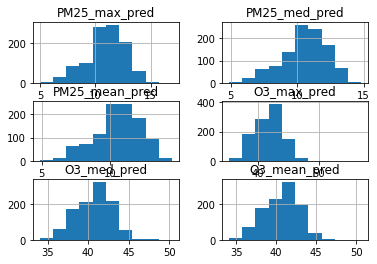

In [10]:
check_df.hist()

In [11]:
# data appears roughly normally distributed--fill nulls with mean

# only feature cols have nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Data columns (total 93 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2672 non-null   int64  
 1   FIPS                 2672 non-null   int64  
 2   recent_trend         2672 non-null   object 
 3   PM25_max_pred        1048 non-null   float64
 4   PM25_med_pred        1048 non-null   float64
 5   PM25_mean_pred       1048 non-null   float64
 6   O3_max_pred          1048 non-null   float64
 7   O3_med_pred          1048 non-null   float64
 8   O3_mean_pred         1048 non-null   float64
 9   PM25_max_pred_2001   1048 non-null   float64
 10  PM25_max_pred_2002   1048 non-null   float64
 11  PM25_max_pred_2003   1048 non-null   float64
 12  PM25_max_pred_2004   1048 non-null   float64
 13  PM25_max_pred_2005   1048 non-null   float64
 14  PM25_max_pred_2006   1048 non-null   float64
 15  PM25_max_pred_2007   1048 non-null   f

In [12]:
col_list = [name for name in df.columns]

col_list = col_list[3:]

for col in col_list:

  df[col].fillna(df[col].mean(), inplace=True)

In [13]:
# check nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Data columns (total 93 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2672 non-null   int64  
 1   FIPS                 2672 non-null   int64  
 2   recent_trend         2672 non-null   object 
 3   PM25_max_pred        2672 non-null   float64
 4   PM25_med_pred        2672 non-null   float64
 5   PM25_mean_pred       2672 non-null   float64
 6   O3_max_pred          2672 non-null   float64
 7   O3_med_pred          2672 non-null   float64
 8   O3_mean_pred         2672 non-null   float64
 9   PM25_max_pred_2001   2672 non-null   float64
 10  PM25_max_pred_2002   2672 non-null   float64
 11  PM25_max_pred_2003   2672 non-null   float64
 12  PM25_max_pred_2004   2672 non-null   float64
 13  PM25_max_pred_2005   2672 non-null   float64
 14  PM25_max_pred_2006   2672 non-null   float64
 15  PM25_max_pred_2007   2672 non-null   f

In [14]:
df.head()

,index,FIPS,recent_trend,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0,0,falling,10.949364,10.546574,10.538006,41.736391,40.679811,40.693274,12.596511,...,41.988971,41.967347,42.174495,40.651883,38.208309,41.13262,41.485925,41.112726,38.688977,38.049843
1,1,1001,stable,10.949364,10.546574,10.538006,41.736391,40.679811,40.693274,12.596511,...,41.988971,41.967347,42.174495,40.651883,38.208309,41.13262,41.485925,41.112726,38.688977,38.049843
2,2,1003,stable,10.949364,10.546574,10.538006,41.736391,40.679811,40.693274,12.596511,...,41.988971,41.967347,42.174495,40.651883,38.208309,41.13262,41.485925,41.112726,38.688977,38.049843
3,3,1005,stable,10.949364,10.546574,10.538006,41.736391,40.679811,40.693274,12.596511,...,41.988971,41.967347,42.174495,40.651883,38.208309,41.13262,41.485925,41.112726,38.688977,38.049843
4,4,1007,stable,10.949364,10.546574,10.538006,41.736391,40.679811,40.693274,12.596511,...,41.988971,41.967347,42.174495,40.651883,38.208309,41.13262,41.485925,41.112726,38.688977,38.049843


In [15]:
# split into predictor and features

X = df.copy()

X = X.drop(['index', 'FIPS', 'recent_trend'], axis=1)

y = df['recent_trend']

In [16]:
# scale data

from sklearn.preprocessing import StandardScaler

data_scaler = StandardScaler()

X_scaled = data_scaler.fit_transform(X)

X_scaled

array([[0.00000000e+00, 0.00000000e+00, 1.71313988e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.71313988e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.71313988e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.71313988e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.71313988e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.71313988e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [42]:
col_names = [name for name in X.columns]

X = pd.DataFrame(data=X_scaled, columns = col_names)

X.head()

,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,PM25_max_pred_2002,PM25_max_pred_2003,PM25_max_pred_2004,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0.0,0.0,1.713140e-15,4.879534e-15,5.186007e-15,0.0,2.410929e-15,1.200231e-15,0.0,1.379576e-15,...,4.859704e-15,0.0,-3.610443e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.713140e-15,4.879534e-15,5.186007e-15,0.0,2.410929e-15,1.200231e-15,0.0,1.379576e-15,...,4.859704e-15,0.0,-3.610443e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.713140e-15,4.879534e-15,5.186007e-15,0.0,2.410929e-15,1.200231e-15,0.0,1.379576e-15,...,4.859704e-15,0.0,-3.610443e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.713140e-15,4.879534e-15,5.186007e-15,0.0,2.410929e-15,1.200231e-15,0.0,1.379576e-15,...,4.859704e-15,0.0,-3.610443e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.713140e-15,4.879534e-15,5.186007e-15,0.0,2.410929e-15,1.200231e-15,0.0,1.379576e-15,...,4.859704e-15,0.0,-3.610443e-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

In [32]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [33]:
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [34]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  91.03
F1 (Polynomial Kernel):  87.48


In [35]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  91.03
F1 (RBF Kernel):  86.75


In [36]:
poly_result = pd.DataFrame({"Prediction": poly_pred, "Actual": y_test}).reset_index(drop=True)

poly_result.head()

,Prediction,Actual
0,stable,falling
1,stable,stable
2,stable,stable
3,stable,stable
4,stable,stable


In [37]:
print(poly_result.Prediction.value_counts())
print(poly_result.Actual.value_counts())

stable     530
falling      5
Name: Prediction, dtype: int64
stable     487
falling     38
rising      10
Name: Actual, dtype: int64


In [38]:
rbf_result = pd.DataFrame({"Prediction": rbf_pred, "Actual": y_test}).reset_index(drop=True)

rbf_result.head()

,Prediction,Actual
0,stable,falling
1,stable,stable
2,stable,stable
3,stable,stable
4,stable,stable


In [39]:
print(rbf_result.Prediction.value_counts())
print(rbf_result.Actual.value_counts())

stable    535
Name: Prediction, dtype: int64
stable     487
falling     38
rising      10
Name: Actual, dtype: int64


In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, poly_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, poly_pred))

              precision    recall  f1-score   support

     falling       0.40      0.05      0.09        38
      rising       0.00      0.00      0.00        10
      stable       0.92      1.00      0.95       487

    accuracy                           0.91       535
   macro avg       0.44      0.35      0.35       535
weighted avg       0.86      0.91      0.87       535



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
